In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy.stats import multivariate_normal
from sklearn.exceptions import ConvergenceWarning

palette = sns.color_palette()
figsize = (12,8)
legend_fontsize = 16

/home/mo/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Часть I. О теореме Байеса

#### Задание 1.

В рамках данной задачи нас интересует вероятность **P(подозреваемый виновен|редкая группа)** того, что подсудимый виновен при условии, что у него именно та редкая группа крови. 

Прокурор же предлагает судье вероятность **P(редкая группа|подозреваемый виновен)** того, что у подсудимого редкая группа крови при условии, что он совершил убийство.

#### Задание 2.

В данном случае адвокат вычисляет совместную вероятность событий **P(редкая группа & подозреваемый виновен)**.

In [ ]:
    1.000.000 людей в городе
     /                      \
    /                        \
10.000 с редкой группой   990.000 с другой группой крови
   /              \
  /                \
1 убийца         9999 невиновных

#### Задание 3.

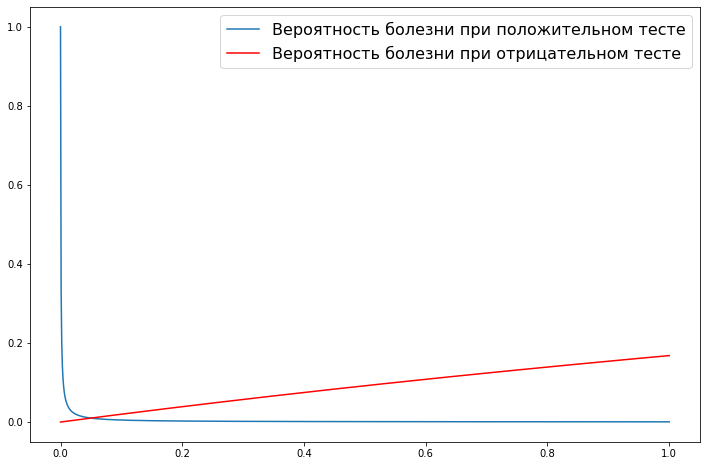

In [2]:
def prob_ill_if_pos(fp, p_ill=0.01, p_miss=0.05):
    return p_miss * p_ill / ( p_miss * p_ill + fp * (1 - p_ill))

def prob_ill_if_neg(fn, p_ill=0.01, p_miss=0.05):
    return fn * p_ill / (fn * p_ill + p_miss * (1 - p_ill))

fp = np.linspace(0, 1, 1000)

result = prob_ill_if_pos(fp)

fn = np.linspace(0, 1, 1000)

result_2 = prob_ill_if_neg(fn)

plt.figure(figsize=figsize)
plt.plot(fp, result);
plt.plot(fn, result_2, c='r');
plt.legend(['Вероятность болезни при положительном тесте', 
            'Вероятность болезни при отрицательном тесте'], prop={'size': legend_fontsize});

Таким образом, можно увидеть, что при увеличении числа ложных срабатываний FP апостериорная вероятность **P(болен|положительный тест)** гиперболически убывает.

Напротив, при уменьшении числа FN апостериорная вероятность **P(болен|отрицательный тест)** линейно возрастает.


Таким образом, если гнаться за числовыми показателя теста болезни, достаточно уменьшать значение FP.
Однако, учитывая специфику области опредления теста, гораздо важнее **уменьшать количество FN**, что и рекомендуется осуществить медикам.

### Часть II. О линейной регрессии

#### Задание 1.

In [3]:
def bayesian_update(mu, sigma, x, y, sigma_noise=0.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ 
                            (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), 
                                        np.transpose(mu)) + (1 / (sigma_noise ** 2)) * 
                     np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n


def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

def plot_predictions(xs, mu, x, points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(np.mean(x, axis=0) - np.std(x, axis=0)), 
                    np.exp(np.mean(x, axis=0) + np.std(x, axis=0)), 
                    color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)
    
    
def bayesian_update_2(mu, sigma, x, y, sigma_noise=0.25):
    x_matrix = np.array([[1, x, x ** 2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + 
                            (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), 
                                        np.transpose(mu)) + (1 / (sigma_noise ** 2)) * 
                     np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

def sample_statistics_2(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i, w in enumerate(my_w):
        res[i,:] = w[0] + w[1] * xs + w[2] * (xs ** 2)
    return res

def plot_predictions_2(xs, mu, x, points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.plot(xs, np.exp(mu[2] * (xs ** 2) + mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(np.mean(x, axis=0) - np.std(x, axis=0)), 
                    np.exp(np.mean(x, axis=0) + np.std(x, axis=0)), 
                    color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

In [4]:
data = pd.read_csv('owid-covid-data.csv', parse_dates=['date'], index_col=['date'])
data = data[data.location == 'Russia']

data = data[data.index >= '2020-03-03']
data.new_cases[data.new_cases == 0] = 1.

total_cases = data.total_cases
new_cases = data.new_cases

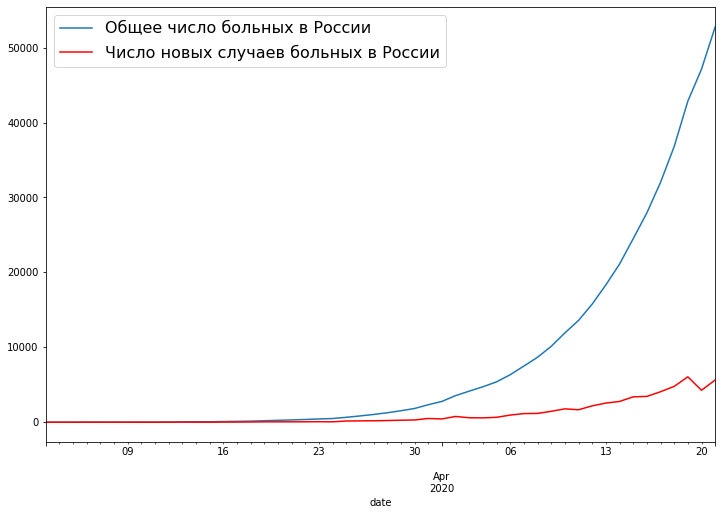

In [5]:
plt.figure(figsize=figsize)

total_cases[:50].plot();
new_cases[:50].plot(c='r');
plt.legend(['Общее число больных в России', 
            'Число новых случаев больных в России'], prop={'size': legend_fontsize});

#### Задание 2.

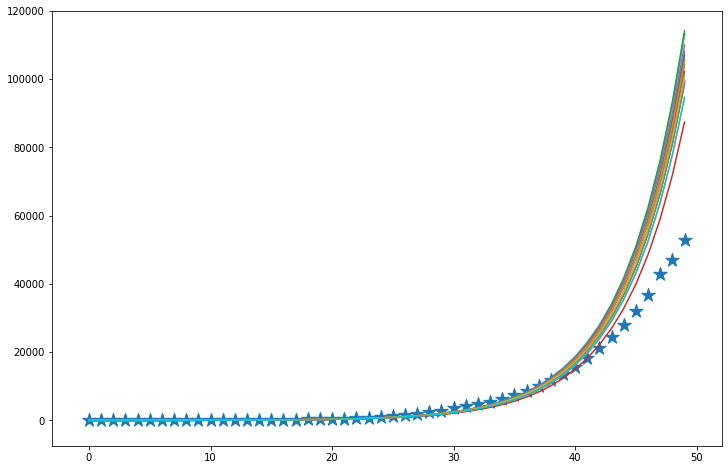

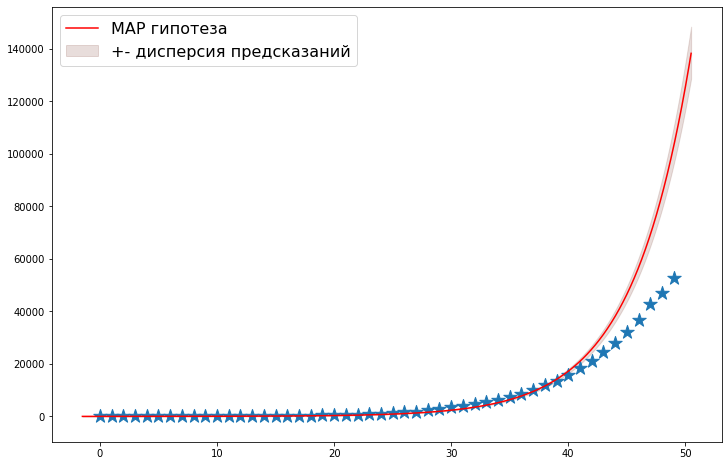

In [6]:
nums = 50
xd = np.arange(nums)
xs = np.arange(xd[0]-1.5, xd[-1] + 1.5, 0.01)
cur_mu, cur_sigma = np.array([0, 0]), np.array([[1, 0], [0, 1]])

points = [[], []]

for i in range(0, nums):
    px, py = xd[i], np.log(total_cases.values[i])
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)
    points[0].append(px)
    points[1].append(np.exp(py))
    
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for _ in range(20):
    u_1, u_2 = np.random.multivariate_normal(mean=cur_mu, cov=cur_sigma)
    ax.plot(np.exp(u_1 + u_2 * xd));
ax.scatter(points[0], points[1], marker='*', s=200);
    
x = sample_statistics(cur_mu, cur_sigma, xs, n=1000)
plot_predictions(xs, cur_mu, x, points)

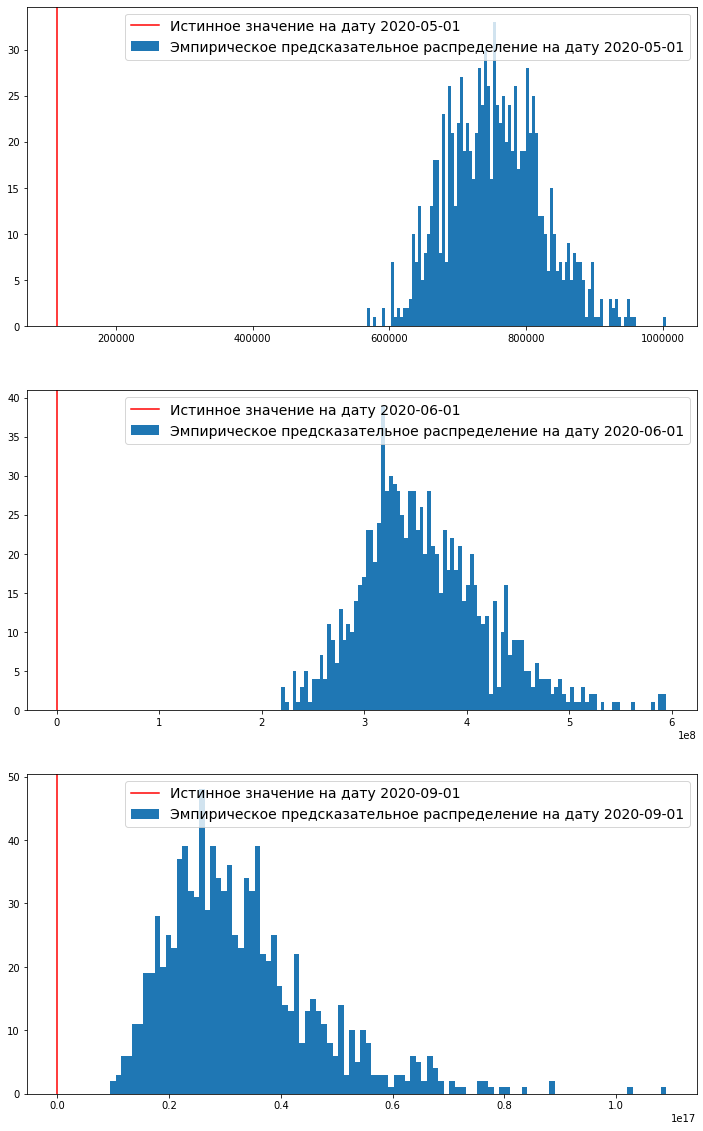

In [7]:
report_dates = ['2020-05-01', '2020-06-01', '2020-09-01']
fig, axs = plt.subplots(3, 1, figsize=(12,20))
for i, date in enumerate(report_dates):
    day_num = (np.datetime64(date) - np.datetime64('2020-03-03') ) / np.timedelta64(1, 'D')
    result = []
    for _ in range(1000):
        u_1, u_2 = np.random.multivariate_normal(mean=cur_mu, cov=cur_sigma)
        result.append(np.exp(u_1 + u_2 * day_num))
    result = np.array(result)
    true_value = total_cases[total_cases.index==date].values[0]
    axs[i].hist(result, bins=100)
    axs[i].axvline(x=true_value, c='r')
    axs[i].legend(['Истинное значение на дату ' + date, 
                   'Эмпирическое предсказательное распределение на дату ' + date], 
                  prop={'size': legend_fontsize-2})

#### Задание 3.

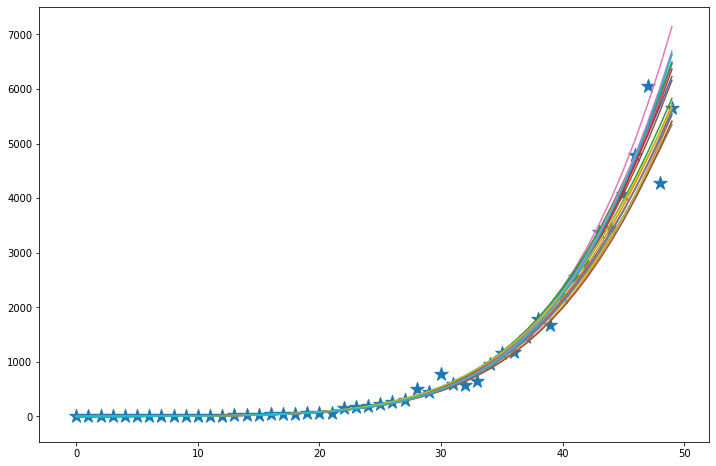

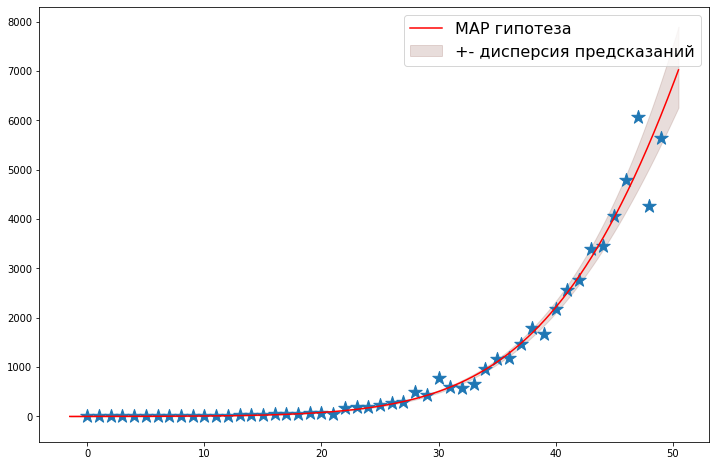

In [8]:
xd = np.arange(nums)
xs = np.arange(xd[0]-1.5, xd[-1] + 1.5, 0.01)
cur_mu, cur_sigma = np.array([0, 0, 0]), np.eye(3, dtype=int)

points = [[], []]

for i in range(0, nums):
    px, py = xd[i], np.log(new_cases.values[i])
    cur_mu, cur_sigma = bayesian_update_2(cur_mu, cur_sigma, px, py)
    points[0].append(px)
    points[1].append(np.exp(py))

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for _ in range(20):
    u = np.random.multivariate_normal(mean=cur_mu, cov=cur_sigma)
    ax.plot(np.exp(u[0] + u[1] * xd + u[2] * (xd ** 2)));
ax.scatter(points[0], points[1], marker='*', s=200);

x = sample_statistics_2(cur_mu, cur_sigma, xs, n=1000)
plot_predictions_2(xs, cur_mu, x, points)

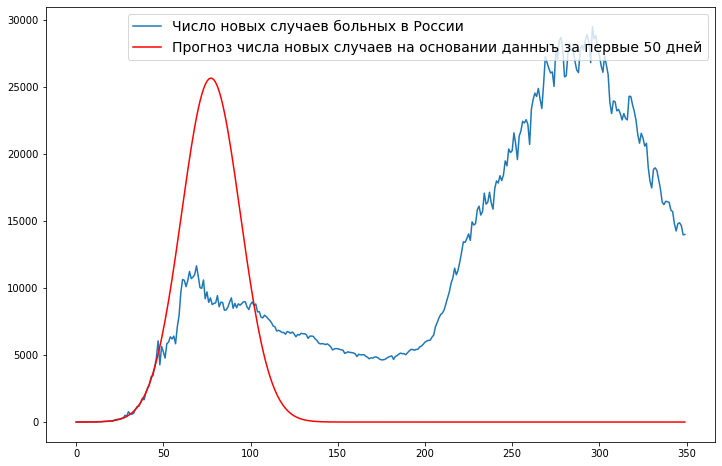

In [9]:
x = np.arange(new_cases.shape[0]) 
temp_u = []
for _ in range(20):
    temp_u.append(np.random.multivariate_normal(mean=cur_mu, cov=cur_sigma))
temp_u = np.array(temp_u)
u = temp_u.mean(axis=0)
plt.figure(figsize=figsize);
plt.plot(x, new_cases.values);
plt.plot(x, np.exp(u[0] + u[1] * x + u[2] * (x ** 2)), c='r');
plt.legend(['Число новых случаев больных в России',
            'Прогноз числа новых случаев на основании данныъ за первые 50 дней'], 
           prop={'size': legend_fontsize - 2});

In [10]:
result = []
for _ in range(100):
    i = 0
    temp = []
    u = np.random.multivariate_normal(mean=cur_mu, cov=cur_sigma)
    t = np.exp(u[0] + u[1] * i + u[2] * (i ** 2))
    while t > 0.5:
        temp.append(t)
        i += 1
        t = np.exp(u[0] + u[1] * i + u[2] * (i ** 2))
    result.append(int(np.sum(temp)))
    
print(f"""Итоговый прогноз общего числа больных в России - {int(np.mean(result))}
Пессимистичный прогноз общего числа больных в России - {int(np.percentile(result, 90))}
Оптимистичный прогноз общего числа больных в России - {int(np.percentile(result, 10))}
Реальное итоговое число больных в России - {int(total_cases.max())}""")

Итоговый прогноз общего числа больных в России - 1201118
Пессимистичный прогноз общего числа больных в России - 2163948
Оптимистичный прогноз общего числа больных в России - 514527
Реальное итоговое число больных в России - 4040505
